# Applying privacy metrics to ML models

In this notebook we will demonstrate how to apply both the PDTP and the SHAPr privacy metrics to random forest and decision tree classifiers trained on the nursery dataset.

Load data and train random forest model

In [10]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import warnings
warnings.filterwarnings('ignore')

import numpy as np

from art.metrics import PDTP, SHAPr
from art.utils import load_nursery

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification.scikitlearn import ScikitlearnRandomForestClassifier, ScikitlearnDecisionTreeClassifier

(x_train, y_train), (x_test, y_test), _, _ = load_nursery(test_set=0.5)

model = RandomForestClassifier()
model.fit(x_train, y_train)
# An extra (unfitted) model of the same type is needed for the PDTP metric to fit alternative models and compare their outputs
extra_model = RandomForestClassifier()

# ART wrappers for models
art_classifier = ScikitlearnRandomForestClassifier(model)
extra_classifier = ScikitlearnRandomForestClassifier(extra_model)

# We will run the PDTP metric only on a subset of the training samples, since it is quite slow
num_samples = 100

Compute PDTP metric for random forest model

In [11]:
indexes = np.array(range(num_samples))
leakage, _, _ = PDTP(art_classifier, extra_classifier, x_train, y_train, indexes=indexes)

print("Average PDTP leakage random forest: ", np.average(leakage))
print("Max PDTP leakage random forest: ", np.max(leakage))

Average PDTP leakage random forest:  18.778
Max PDTP leakage random forest:  22.0


Train decision tree model

In [12]:
model2 = DecisionTreeClassifier()
model2.fit(x_train, y_train)
extra_model2 = DecisionTreeClassifier()

art_classifier2 = ScikitlearnDecisionTreeClassifier(model2)
extra_classifier2 = ScikitlearnDecisionTreeClassifier(extra_model2)

Compute PDTP metric for decision tree model

In [13]:
leakage2, _, _ = PDTP(art_classifier2, extra_classifier2, x_train, y_train, indexes=indexes, num_iter=1)
print("Average PDTP leakage decision tree: ", np.average(leakage2))
print("Max PDTP leakage decision tree: ", np.max(leakage2))

Average PDTP leakage decision tree:  1.0
Max PDTP leakage decision tree:  1.0


Compute SHAPr metric for both models

In [14]:
SHAPr_leakage = SHAPr(art_classifier, x_train, y_train, x_test, y_test)
print("Average SHAPr leakage random forest: ", np.average(SHAPr_leakage))
print("Max SHAPr leakage random forest: ", np.max(SHAPr_leakage))

SHAPr_leakage2 = SHAPr(art_classifier2, x_train, y_train, x_test, y_test)
print("Average SHAPr leakage decision tree: ", np.average(SHAPr_leakage2))
print("Max SHAPr leakage decision tree: ", np.max(SHAPr_leakage2))

Average SHAPr leakage random forest:  0.97360295
Max SHAPr leakage random forest:  3.2778597
Average SHAPr leakage decision tree:  0.981167
Max SHAPr leakage decision tree:  1.003879


Compare the leakage metrics for the 20 first training samples (random forest)

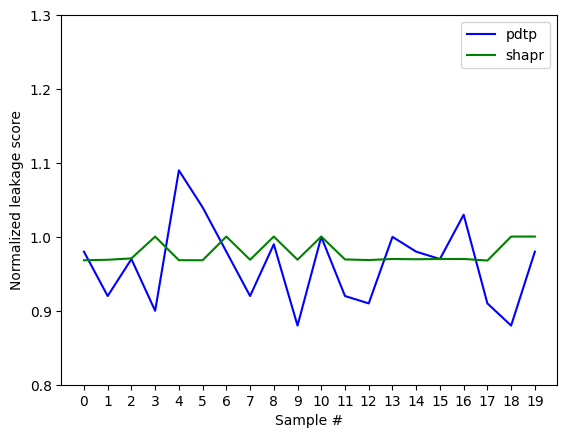

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(20), leakage[:20] / 20, label="pdtp", color="blue")
plt.plot(range(20), SHAPr_leakage[:20], label="shapr", color="green")
plt.xticks(range(20))
plt.ylim(0.8, 1.3)
plt.xlabel("Sample #")
plt.ylabel("Normalized leakage score")
plt.legend()
plt.show()

Compare the leakage metrics for the 20 first training samples (decision tree)

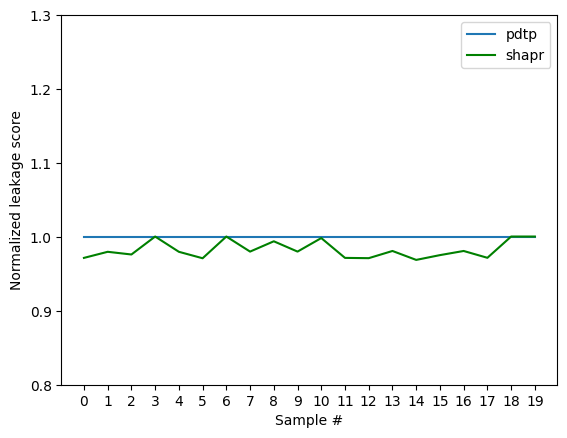

In [17]:
plt.plot(range(20), leakage2[:20], label="pdtp")
plt.plot(range(20), SHAPr_leakage2[:20], label="shapr", color="green")
plt.xticks(range(20))
plt.ylim(0.8, 1.3)
plt.xlabel("Sample #")
plt.ylabel("Normalized leakage score")
plt.legend()
plt.show()

Run a membership inference attack against each model so we can compare attack results with leakage metrics

In [19]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

attack_train_ratio = 0.5
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_train_ratio)

# random forest
bb_attack = MembershipInferenceBlackBox(art_classifier)

# train attack model
bb_attack.fit(x_train[attack_train_size:], y_train[attack_train_size:],
              x_test[attack_test_size:], y_test[attack_test_size:])

# get inferred values
inferred_train_bb = bb_attack.infer(x_train[:attack_train_size], y_train[:attack_train_size])
inferred_test_bb = bb_attack.infer(x_test[:attack_test_size], y_test[:attack_test_size])
# check accuracy
train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print(train_acc)
print(test_acc)
print(acc)

0.749922815683853
0.5529484408768138
0.6514356282803334


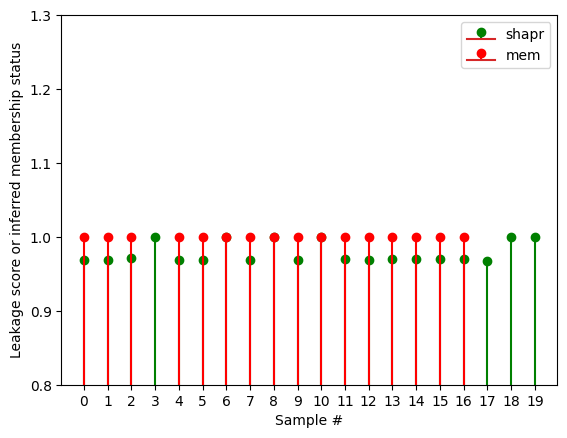

In [20]:
import matplotlib.pyplot as plt
plt.stem(range(20), SHAPr_leakage[:20], label="shapr", linefmt="green")
plt.stem(range(20), inferred_train_bb[:20], label="mem", linefmt="red")
plt.xticks(range(20))
plt.ylim(0.8, 1.3)
plt.xlabel("Sample #")
plt.ylabel("Leakage score or inferred membership status")
plt.legend()
plt.show()

In [21]:
# decision tree
bb_attack2 = MembershipInferenceBlackBox(art_classifier2)

# train attack model
bb_attack2.fit(x_train[attack_train_size:], y_train[attack_train_size:],
              x_test[attack_test_size:], y_test[attack_test_size:])

# get inferred values
inferred_train_bb2 = bb_attack2.infer(x_train[:attack_train_size], y_train[:attack_train_size])
inferred_test_bb2 = bb_attack2.infer(x_test[:attack_test_size], y_test[:attack_test_size])

# check accuracy
train_acc2 = np.sum(inferred_train_bb2) / len(inferred_train_bb2)
test_acc2 = 1 - (np.sum(inferred_test_bb2) / len(inferred_test_bb2))
acc2 = (train_acc2 * len(inferred_train_bb2) + test_acc2 * len(inferred_test_bb2)) / (len(inferred_train_bb2) + len(inferred_test_bb2))
print(train_acc2)
print(test_acc2)
print(acc2)

0.6384686631676443
0.35504785427601115
0.4967582587218277


In [22]:
inferred_train_bb2_prob = bb_attack2.infer(x_train[:attack_train_size], y_train[:attack_train_size], probabilities=True)

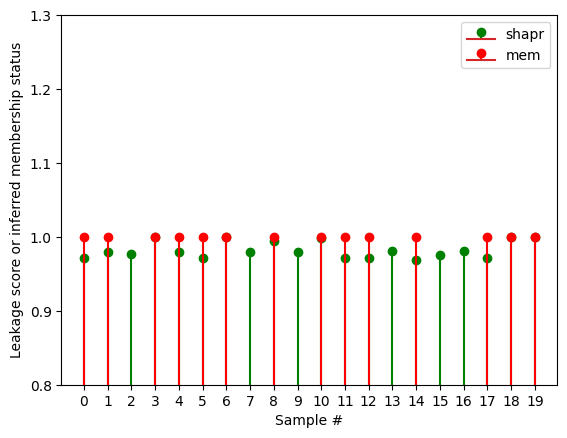

In [23]:
plt.stem(range(20), SHAPr_leakage2[:20], label="shapr", linefmt="green", use_line_collection=True)
plt.stem(range(20), inferred_train_bb2[:20], label="mem", linefmt="red", use_line_collection=True)
plt.xticks(range(20))
plt.ylim(0.8, 1.3)
plt.xlabel("Sample #")
plt.ylabel("Leakage score or inferred membership status")
plt.legend()
plt.show()

Check if there is a correlation between each of the metric types:

In [24]:
import scipy

print(scipy.stats.pearsonr(SHAPr_leakage[:num_samples], leakage))

PearsonRResult(statistic=0.0035381536213372118, pvalue=0.9721301309040974)
